# 第一题

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
TRUE_V = np.arange(7) / 6.0
print("TURE Values:{}".format(TRUE_V))

V = np.zeros(7)
V[1:6] = 0.5
V[6] = 1
print("Initial Values:{}".format(V))

LEFT = 0
RIGHT = 1

TURE Values:[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
Initial Values:[0.  0.5 0.5 0.5 0.5 0.5 1. ]


In [2]:
def td(V, alpha=0.1):
    state = 3
    while True:
        if np.random.binomial(1, 0.5) == LEFT:
            next_state = state - 1
        else:
            next_state = state + 1
        reward = 0 # 利用trick，设置所有的奖励为0
        V[state] += alpha * (reward + V[next_state] - V[state])
        if next_state == 6 or next_state == 0:
            break
        state = next_state

In [3]:
def plot_value_with_episodes():
    episodes = [0, 1, 10, 100]
    curr_V = np.copy(V)
    for i in range(episodes[-1] + 1):
        if i in episodes:
            plt.plot(curr_V, label="{} episodes".format(i))
        td(curr_V)
    plt.plot(TRUE_V, label="true values")
    plt.xlabel('state')
    plt.ylabel('estimated value')
    plt.legend()

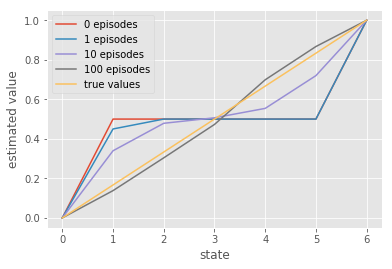

In [4]:
plot_value_with_episodes()

In [5]:
N = 100 # 重复实验次数
alphas =[0.15, 0.1, 0.05]
max_episode = 100 + 1

In [6]:
def RMS(curr_V):
    return np.sqrt(np.sum(np.power(TRUE_V - curr_V, 2)) / 5.0)

In [7]:
def plot_td_rms():
    all_errors = dict() # 存好曲线的信息以为了和MC方法对比
    for i, alpha in enumerate(alphas):
        mean_errors = np.zeros(max_episode)
        for n in range(N):
            curr_V = np.copy(V)
            errors = []
            for e in range(max_episode):
                errors.append(RMS(curr_V))
                td(curr_V, alpha)
            mean_errors += np.asarray(errors)
        mean_errors /= N
        all_errors[alpha] = mean_errors
        plt.plot(mean_errors, label="alpha={}".format(alpha))
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()
    return all_errors

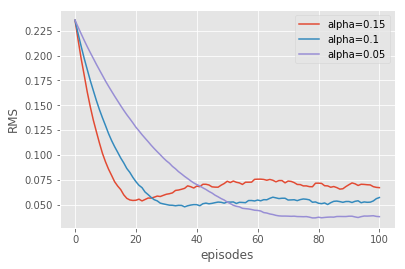

In [8]:
TD_errors = plot_td_rms()


接下来我们实现常量步长的MC算法



In [9]:
def MC(V, alpha=0.1):
    state = 3
    trajectory = [state]
    while True:
        if np.random.binomial(1, 0.5) == LEFT:
            state -= 1
        else:
            state += 1
        trajectory.append(state)
        # 如果在左边状态终止，那么所有的回报值为0
        # 如果在右边状态终止，那么所有的回报值为1
        if state == 6:
            g = 1.0
            break
        elif state == 0:
            g = 0.0
            break
    for s in trajectory:
        V[s] += alpha * (g - V[s])

In [10]:

def plot_mc_rms():
    all_errors = dict() # 存好曲线的信息以为了和TD方法对比
    for i, alpha in enumerate(alphas):
        mean_errors = np.zeros(max_episode)
        for n in range(N):
            curr_V = np.copy(V)
            errors = []
            for e in range(max_episode):
                errors.append(RMS(curr_V))
                MC(curr_V, alpha)
            mean_errors += np.asarray(errors)
        mean_errors /= N
        all_errors[alpha] = mean_errors
        plt.plot(mean_errors, label="alpha={}".format(alpha))
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()
    return all_errors

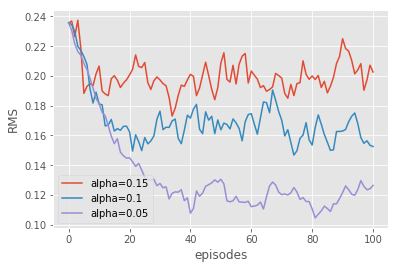

In [11]:
MC_errors = plot_mc_rms()

接下来我们将TD(0)和MC画在同一张图上，然后比较两者的收敛速度






In [12]:
def compare_td_mc(TD_errors, MC_errors):
    for prefix, errors in zip(['TD', 'MC'], [TD_errors, MC_errors]):
        for alpha, mean_errors in errors.items():
            plt.plot(mean_errors, label='{}, alpha={}'.format(prefix, alpha))
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()

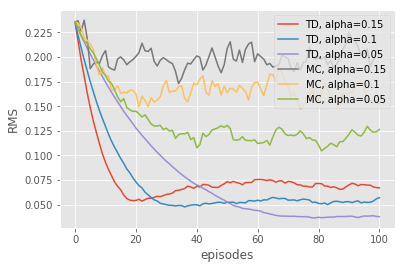

In [13]:
compare_td_mc(TD_errors, MC_errors)

可以看出在相同的步长情况下，TD(0)算法的收敛速度要快于MC算法




# 第二题





In [14]:
WORLD_HEIGHT = 4
WORLD_WIDTH = 12
GAMMA = 1
EPSILON = 0.1
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]
START = [3, 0]
GOAL = [3, 11]

In [15]:
class ENV:
    def __init__(self):
        self.START = [3, 0]
        self.GOAL = [3, 11]
        self.WORLD_WIDTH = WORLD_WIDTH
        self.WORLD_HEIGHT = WORLD_HEIGHT
    
    def step(self, s, a):
        i, j = s
        if a == UP:
            next_S = [max(i - 1, 0), j]
        elif a == LEFT:
            next_S = [i, max(j - 1, 0)]
        elif a == RIGHT:
            next_S = [i, min(j + 1, self.WORLD_WIDTH - 1)]
        elif a == DOWN:
            next_S = [min(i + 1, self.WORLD_HEIGHT - 1), j]
        else:
            raise ValueError
        reward = -1
        if next_S[0] == 3 and 1 <= next_S[1] <= 10:
            reward = -100
            next_S = self.START
        terminal = False
        if next_S == self.GOAL:
            terminal = True
        return next_S, reward, terminal

In [16]:
def choose_action_by_epsilon_greedy(state, Q):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        values = Q[state[0], state[1]]
        return np.random.choice([a for a, v in enumerate(values) if v == np.max(values)])

In [17]:
def sarsa(env, Q, alpha=0.5):
    s = env.START
    a = choose_action_by_epsilon_greedy(s, Q)
    g = 0
    while s != GOAL:
        next_S, r, term = env.step(s, a)
        next_a =  choose_action_by_epsilon_greedy(next_S, Q)
        g += GAMMA * r
        td_target = r + GAMMA * Q[next_S[0], next_S[1], next_a]
        Q[s[0], s[1], a] += alpha * (td_target - Q[s[0], s[1], a])
        s = next_S
        a = next_a
    return g 

In [22]:
def plot_sarsa(episodes=500, N=50):
    mean_returns = np.zeros(episodes)
    env = ENV()
    for n in range(N):
        Q = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
        for i in range(episodes):
            mean_returns[i] += sarsa(env, Q)
    mean_returns /= N
    plt.plot(mean_returns)
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.ylim([-100, 0])
    return mean_returns

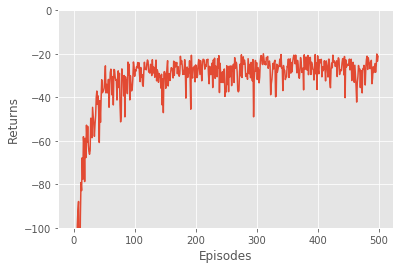

In [23]:
sarsa_returns = plot_sarsa()

In [24]:
from IPython.display import Latex
from IPython.display import display

def print_optimal_policy(Q):
    ACTION_LATEX_LISTS = [r'\uparrow', r'\downarrow', r'\leftarrow', r'\rightarrow']
    policy_list = []
    for i in range(0, WORLD_HEIGHT):
        one_column_list = []
        for j in range(0, WORLD_WIDTH):
            if [i, j] == GOAL:
                one_column_list.append('G')
                continue
            if i == 3 and 1 <= j <= 10:
                one_column_list.append('\square')
                continue
            max_a = np.argmax(Q[i, j])
            one_column_list.append(ACTION_LATEX_LISTS[max_a])
        one_column_str = '&'.join(one_column_list)
        policy_list.append(one_column_str)
    policy_str = r'$$\begin{bmatrix}' + r'\\'.join(policy_list) + r'\end{bmatrix}$$'
    display(Latex(policy_str))

In [25]:
def plot_sarsa_policy(episodes=1000): # 要找到最优策略可能需要训练更多的片段数
    env = ENV()
    Q = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    for i in range(episodes):
        sarsa(env, Q)
    print_optimal_policy(Q)

In [26]:
plot_sarsa_policy()

<IPython.core.display.Latex object>

Q learning




In [27]:
def q_learning(env, Q, alpha=0.5):
    s = env.START
    g = 0
    while s != GOAL:
        a = choose_action_by_epsilon_greedy(s, Q)
        next_S, r, term = env.step(s, a)
        g += GAMMA * r
        td_target = r + GAMMA * np.max(Q[next_S[0], next_S[1]])
        Q[s[0], s[1], a] += alpha * (td_target - Q[s[0], s[1], a])
        s = next_S
    return g

In [28]:
def plot_q_learning(episodes=500, N=50):
    mean_returns = np.zeros(episodes)
    env = ENV()
    for n in range(N):
        Q = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
        for i in range(episodes):
            mean_returns[i] += q_learning(env, Q)
    mean_returns /= N
    plt.plot(mean_returns)
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.ylim([-100, 0])
    return mean_returns

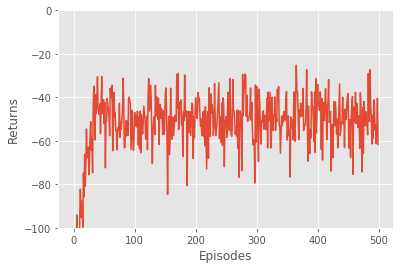

In [29]:
q_returns = plot_q_learning()

In [30]:
def plot_q_policy(episodes=1000): # 要找到最优策略可能需要训练更多的片段数
    env = ENV()
    Q = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    for i in range(episodes):
        q_learning(env, Q)
    print_optimal_policy(Q)

In [31]:
plot_q_policy()

<IPython.core.display.Latex object>

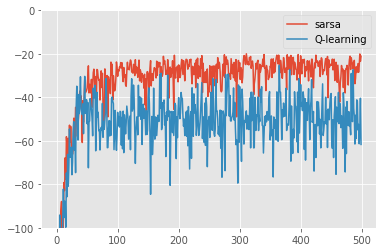

In [32]:
plt.plot(sarsa_returns, label='sarsa')
plt.plot(q_returns, label='Q-learning')
plt.ylim([-100, 0])
plt.legend()